In [2]:
import math
from typing import Optional

import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import PosteriorTransform
from botorch.exceptions import UnsupportedError
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import Model
from botorch.utils.constants import get_constants_like
from botorch.utils.probability import MVNXPB
from botorch.utils.probability.utils import (
    log_ndtr as log_Phi,
    log_phi,
    log_prob_normal_in,
    ndtr as Phi,
    phi,
)
from botorch.utils.safe_math import log1mexp, logmeanexp
from botorch.utils.transforms import convert_to_target_pre_hook, t_batch_mode_transform
from torch import Tensor
from torch.nn.functional import pad
from botorch.test_functions import Hartmann, Ackley, Beale
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qKnowledgeGradient

In [14]:
class DiverseAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(self, model, lambda_, epsilon_, best_f):
        super().__init__(model=model)
        self.register_buffer("lambda_", torch.as_tensor(lambda_))
        self.register_buffer("epsilon_", torch.as_tensor(epsilon_))
        self.register_buffer("best_f", torch.as_tensor(best_f))

    @t_batch_mode_transform(expected_q = 1)
    def forward(self, X: Tensor) -> Tensor:
        mean, sigma = self._mean_and_sigma(X)
        factor = (1 + self.epsilon_ ) if self.best_f > 0 else (1 - self.epsilon_)
        
        ei_portion = Phi((self.best_f - mean)/sigma) * (self.best_f - mean)
        dei_portion = phi((self.best_f - mean)/sigma) + self.lambda_ * Phi((factor * self.best_f - mean)/sigma)
        
        return ei_portion + dei_portion * sigma

In [4]:
import warnings
warnings.filterwarnings("ignore")
from botorch.test_functions import Hartmann, Ackley, Branin, Bukin, DropWave

In [5]:
def scalarize_input(train_x, bounds):
    train_x_i = torch.clone(train_x)
    for dim in range(bounds.shape[1]):
        bound = bounds[:, dim]
        train_x_i[:, dim] -= bound[0]
        train_x_i[:, dim] /= ((bound[1] - bound[0]))
    return train_x_i

def revert_input(train_x_i, bounds):
    train_x = torch.clone(train_x_i)
    for dim in range(bounds.shape[1]):
        bound = bounds[:, dim]
        train_x[:, dim] *= ((bound[1] - bound[0]))
        train_x[:, dim] += bound[0]
    return train_x
    
def scalarize_output(train_obj):
    mean = train_obj.mean()
    std = train_obj.std()
    return (train_obj - mean)/std, mean, std

def revert_output(train_obj, mean, std):
    return train_obj * std + mean
    
def bayes_opt_loop(opt_func, bounds, num_start, num_sim, acf_func, param_settings = {}):
    dim = bounds.shape[1]
    
    #actual observed 
    obs_x = revert_input(torch.rand(num_start, dim), bounds)
    obs_obj = opt_func(obs_x).unsqueeze(-1)
    
    #regularized inputs to model
    model_bounds = torch.tensor([[0.0] * dim, [1.0] * dim])
    model_input = scalarize_input(obs_x, bounds)
    model_output, mean, sigma = scalarize_output(obs_obj)
    var = torch.zeros(model_output.shape) + 10**(-6)

    model = FixedNoiseGP(train_X = model_input, train_Y = model_output, train_Yvar = var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    acf_func = acf_func(model = model, best_f = model_output.min(), **param_settings)

    for i in range(num_sim):
        best_f = model_output.min()
        acf_func.model = model
        acf_func.best_f = best_f
        
        new_point, _ = optimize_acqf(acf_func, bounds=model_bounds, q = 1, num_restarts = 5, raw_samples = 100)
        eval_point = revert_input(new_point, bounds)
        eval_result = opt_func(eval_point).expand(1, 1)
        reg_eval_result = (eval_result - mean)/sigma

        model_input = torch.cat((model_input, new_point), 0)
        model_output = torch.cat((model_output, reg_eval_result), 0)
        var = torch.cat((var, torch.as_tensor(10**-6).expand(1,1)), 0)

        #condition observation
        
        model = model.condition_on_observations(X = new_point, Y = reg_eval_result, 
                                                noise = torch.as_tensor(5 * 10**-1).expand(1,1))

        #change parameters for output and refit model
        if i % 50 == 0:
            model_output = revert_output(model_output, mean, sigma)
            model_output, mean, sigma = scalarize_output(model_output)
            model = FixedNoiseGP(train_X = model_input, train_Y = model_output, train_Yvar = var)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_mll(mll)

    obs_x = revert_input(model_input, bounds)
    obs_obj = revert_output(model_output, mean, sigma)
    return obs_x, obs_obj

In [6]:
def evaluate(true_min, train_obj, train_x, epsilon_):
    factor = (1 + epsilon_) if true_min > 0 else (1 - epsilon_)

    torch_ind = train_obj < factor * true_min
    ind = []
    i = 0
    for val in torch_ind:
        if val:
            ind.append(i)
        i += 1

    feasible_sol, feasible_x = train_obj[ind], train_x[ind]
    max_dist = 0 

    for i in range(feasible_sol.shape[0]):
        for j in range(i + 1, feasible_sol.shape[0]):
            val1, val2 = feasible_x[i], feasible_x[j]
            max_dist = max(max_dist, torch.norm(val1 - val2))
    
    max_d = -1 if max_dist == 0 else max_dist.item()
        
    return feasible_sol, feasible_x, max_d

In [7]:
import pandas as pd 
func = [[Bukin(), torch.tensor([[-15.0, -3.0], [-5.0, 3.0]]), 0.5, "Bukin"],
        [DropWave(), torch.tensor([[-5.12] * 2, [5.12] * 2]), -0.7, "DropWave"],
        [Branin(), torch.tensor([[-4.9, -0.1], [0.1, 14.9]]), 0.5, "Branin"],
        [Hartmann(dim=6, negate=False), torch.tensor([[0.0] * 6, [1.0] * 6]), -3, "Hartmann"],
        [Ackley(dim = 2), torch.tensor([[-32.0] * 2, [32.0] * 2]), 0.5, "Ackley"]
        ]

DEI_param_settings = {"lambda_":1, "epsilon_":0.2}
EI_param_settings = {"maximize":False}
know_param_settings = {"num_fantasies":50}

acf_func = [(DiverseAcquisitionFunction, DEI_param_settings, "DEI"),
            (ExpectedImprovement, EI_param_settings, "EI"), ]

def testing_loop(num_start, num_sim, func_loop, acf_func, eps):
    columns = ["opt_func", "acf_func", "num_sol", "curr_min", "max_dist"]
    results = pd.DataFrame(columns = columns)
    
    for func_list in func_loop:
        opt_func = func_list[0]
        bounds = func_list[1]
        true_min = func_list[2]
        opt_name = func_list[3]
                                                             
        for acf_list in acf_func:
            acf, settings, acf_name = acf_list     
            
            x, y = bayes_opt_loop(opt_func, bounds, num_start, num_sim, acf, settings)
            
            sol_set, feas_x, max_dist = evaluate(true_min, y, x, eps)
            
            results.loc[len(results)] = [opt_name, acf_name, len(sol_set), y.min().item(), max_dist]
            print("Completed Testing for " + opt_name + " with " + acf_name)
    return results

results = testing_loop(100, 1000, func, acf_func, 0.3)

Completed Testing for Bukin with DEI
Completed Testing for Bukin with EI
Completed Testing for DropWave with DEI
Completed Testing for DropWave with EI
Completed Testing for Branin with DEI
Completed Testing for Branin with EI
Completed Testing for Hartmann with DEI
Completed Testing for Hartmann with EI
Completed Testing for Ackley with DEI
Completed Testing for Ackley with EI


In [8]:
results

,opt_func,acf_func,num_sol,curr_min,max_dist
0,Bukin,DEI,1,0.319073,-1.000000
1,Bukin,EI,0,0.954216,-1.000000
2,DropWave,DEI,623,-0.936244,3.250316
3,DropWave,EI,637,-0.936245,2.742481
4,Branin,DEI,299,0.397889,1.508515
5,Branin,EI,474,0.397886,1.507949
6,Hartmann,DEI,348,-3.319166,1.643935
7,Hartmann,EI,166,-3.293849,1.642064
8,Ackley,DEI,2,0.405245,0.064068
9,Ackley,EI,1,0.296093,-1.000000


Completed for Bukin
Completed for DropWave
Completed for Branin
Completed for Hartmann
Completed for Ackley


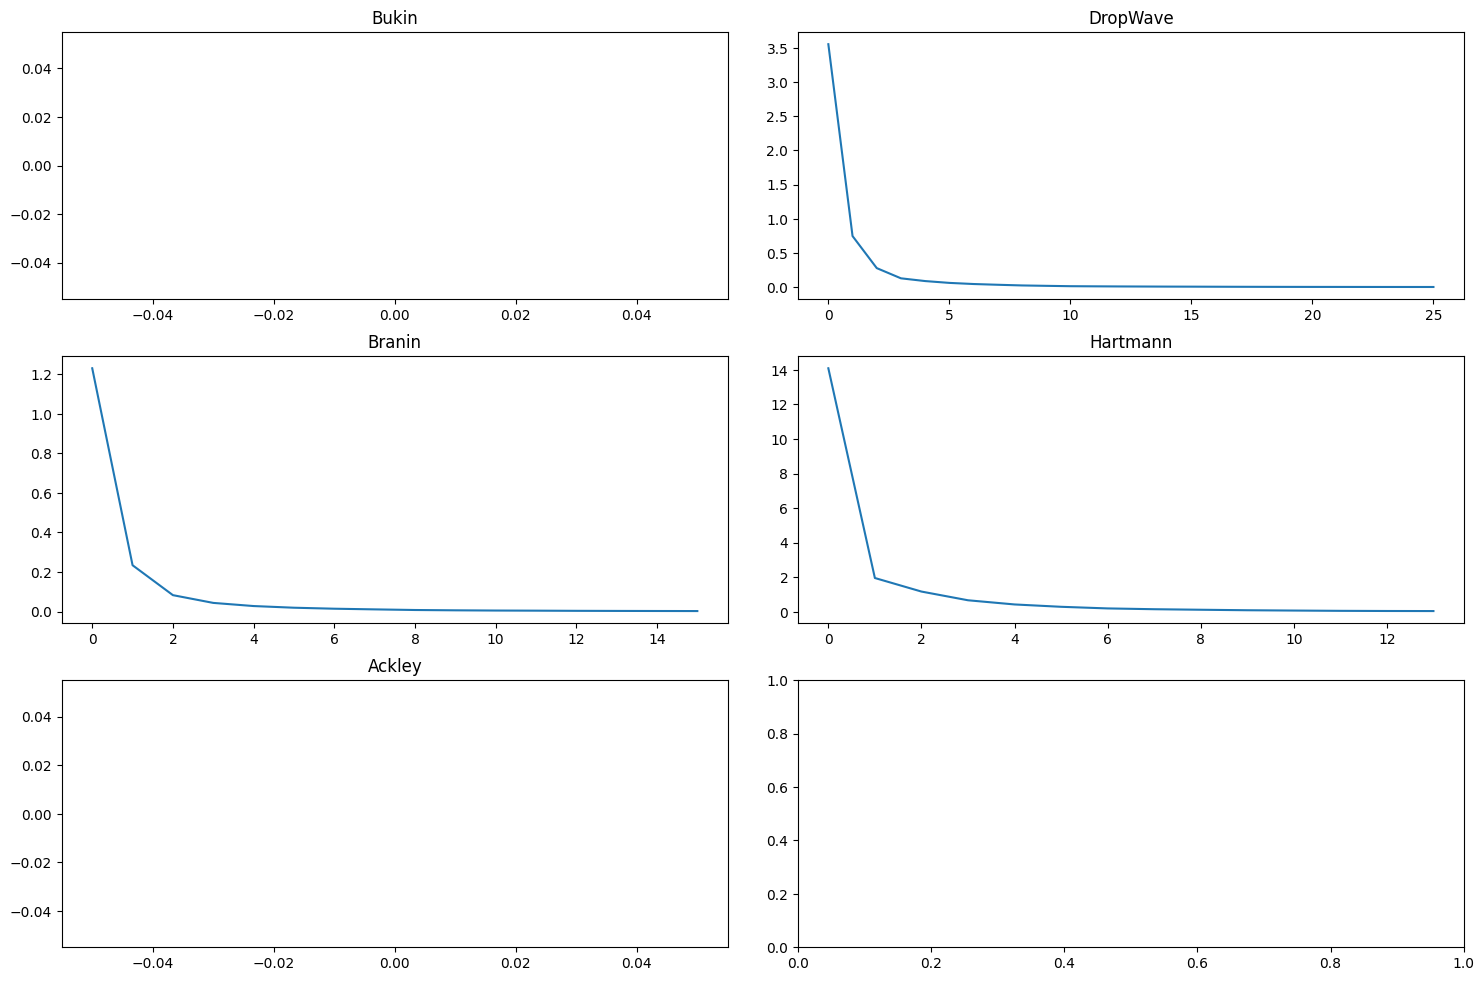

In [56]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


DEI_param_settings = {"lambda_":1, "epsilon_":0.2}

func = [[Bukin(), torch.tensor([[-15.0, -3.0], [-5.0, 3.0]]), 0.5, "Bukin"],
        [DropWave(), torch.tensor([[-5.12] * 2, [5.12] * 2]), -0.7, "DropWave"],
        [Branin(), torch.tensor([[-4.9, -0.1], [0.1, 14.9]]), 0.5, "Branin"],
        [Hartmann(dim=6, negate=False), torch.tensor([[0.0] * 6, [1.0] * 6]), -3, "Hartmann"],
        [Ackley(dim = 2), torch.tensor([[-32.0] * 2, [32.0] * 2]), 0.5, "Ackley"]
        ]

def calculate_WSS(points, max_k):
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += np.linalg.norm(curr_center - points[i]) ** 2
        sse.append(curr_sse)
    return sse

def DEI_optimize_and_cluster(num_start, num_sim, func_loop, settings, eps):
    
    map_res = {}
    for func_list in func_loop:
        opt_func = func_list[0]
        bounds = func_list[1]
        true_min = func_list[2]
        opt_name = func_list[3]
        
        x,y = bayes_opt_loop(opt_func, bounds, num_start, num_sim, DiverseAcquisitionFunction, settings)
        sol_set, feas_x, max_dist = evaluate(true_min, y, x, eps)
        sse = calculate_WSS(sol_set.numpy(), int(np.sqrt(len(sol_set))))
        
        map_res[opt_name] = sse
        print("Completed for " + opt_name)
    
    return map_res

def analyze_cluster(res, specs, figsize = (15,10)):
    plt.rcParams["figure.figsize"] = figsize
    fig, ax = plt.subplots(*specs)
    fig.tight_layout(pad = 2)

    i = 0
    for val in res:
        data = res[val]
        ax[i//col][i%col].plot(data)
        ax[i//col][i%col].set_title(val)
        i += 1
    plt.show()

res = DEI_optimize_and_cluster(100, 1000, func, DEI_param_settings, 0.2)
analyze_cluster(res, (3,2))